In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt

from fbprophet import Prophet
# from fbprophet.utilities import regressor_coefficients

In [2]:
df = pd.read_csv('./data/rent_airbnb_all_features.csv')
print(df.shape)
df.head()

(1752, 37)


,year,quarter,district_code,district_name,neighbourhood_code,neighbourhood_name,price_month(€),price_m2_month(€),From 6 months to 12 motnhs,Over 12 months,...,woman_junior_high_school,woman_senior_high_school,woman_unknown,woman_without education,airbnb_price(€),n_airbnb_listings,availability_365,airbnb_ratio_business,airbnb_professional_ratio,airbnb_mega_host_ratio
0,2015.0,2015-01-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",697.16,11.51,2949.0,8425.0,...,1464.0,2067.0,5.0,470.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015.0,2015-04-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",708.03,12.02,2949.0,8425.0,...,1464.0,2067.0,5.0,470.0,73.343300,903.0,262.921373,0.631229,0.128461,0.016611
2,2015.0,2015-07-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",729.00,14.00,2949.0,8425.0,...,1464.0,2067.0,5.0,470.0,75.124776,1114.0,259.641831,0.607720,0.106822,0.002693
3,2015.0,2015-10-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",751.60,13.43,2949.0,8425.0,...,1464.0,2067.0,5.0,470.0,72.410441,1111.0,271.629163,0.580558,0.067507,0.001800
4,2016.0,2016-01-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",759.16,12.94,2563.0,7550.0,...,1509.0,2196.0,121.0,376.0,72.739919,992.0,260.639113,0.561492,0.073589,0.000000


## First, simplify columns

In [3]:
def sum_columns_and_drop(df, columns, new_column, position):
    # convert the list of column names into a numeric range
    cols_range = []
    for col in columns:
        index_no = df.columns.get_loc(col)
        cols_range.append(index_no)
    cols_range = np.array(cols_range)
    
    # insert the new colum with the sum of all given columns
    df.insert(position, new_column, df.iloc[:, cols_range].sum(axis=1))
    # drop the old columns and return the dataframe
    return df.drop(columns=columns)


In [4]:
df = sum_columns_and_drop(df, ['2 Spanish', '3 Spanish', '4 espanyols o més'], 'more than 2 Spanish', 13)
df = sum_columns_and_drop(df, ['2 foreigners', '3 foreigners', 'more than 4 foreigners'], 'more than 2 foreigners', 13)
df = sum_columns_and_drop(df, ['Up to 6 months', 'From 6 months to 12 motnhs'], 'short-term unemployment', 9)
df = df.rename(columns={'Over 12 months':'long-term unemployment'})
df = sum_columns_and_drop(df, ['man_without education', 'woman_without education', 'woman_unknown', 'man_unknown'], 'no education', 14)
df = sum_columns_and_drop(df, ['man_elementary_school', 'man_junior_high_school', 'man_senior_high_school',
                               'woman_elementary_school', 'woman_junior_high_school', 'woman_senior_high_school'], 'medium education', 15)
df = sum_columns_and_drop(df, ['man_bachelors_degree', 'woman_bachelors_degree'], 'bachelors degree', 16)


In [5]:
print(df.shape)
df.head()

(1752, 23)


,year,quarter,district_code,district_name,neighbourhood_code,neighbourhood_name,price_month(€),price_m2_month(€),short-term unemployment,long-term unemployment,...,more than 2 Spanish,no education,medium education,bachelors degree,airbnb_price(€),n_airbnb_listings,availability_365,airbnb_ratio_business,airbnb_professional_ratio,airbnb_mega_host_ratio
0,2015.0,2015-01-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",697.16,11.51,11574.0,8425.0,...,3572.0,667.0,11846.0,7482.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015.0,2015-04-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",708.03,12.02,11574.0,8425.0,...,3572.0,667.0,11846.0,7482.0,73.343300,903.0,262.921373,0.631229,0.128461,0.016611
2,2015.0,2015-07-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",729.00,14.00,11574.0,8425.0,...,3572.0,667.0,11846.0,7482.0,75.124776,1114.0,259.641831,0.607720,0.106822,0.002693
3,2015.0,2015-10-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",751.60,13.43,11574.0,8425.0,...,3572.0,667.0,11846.0,7482.0,72.410441,1111.0,271.629163,0.580558,0.067507,0.001800
4,2016.0,2016-01-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",759.16,12.94,10754.0,7550.0,...,3534.0,752.0,11759.0,7573.0,72.739919,992.0,260.639113,0.561492,0.073589,0.000000


In [6]:
# rename 'quarter' as 'ds' and 'price_month(€)' as 'y', to use the fbprophet library
df = df.rename(columns={'quarter':'ds', 'price_month(€)':'y'})

In [7]:
# convert the 'ds' column to datetime objects
df['ds'] = df['ds'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d')).values

In [8]:
df.isna().sum()

year                           0
ds                             0
district_code                  0
district_name                  0
neighbourhood_code             0
neighbourhood_name             0
y                            118
price_m2_month(€)            119
short-term unemployment        0
long-term unemployment         0
1 Spanish                      0
1 foreigner                    0
more than 2 foreigners         0
more than 2 Spanish            0
no education                   0
medium education               0
bachelors degree               0
airbnb_price(€)              219
n_airbnb_listings            219
availability_365             219
airbnb_ratio_business        219
airbnb_professional_ratio    219
airbnb_mega_host_ratio       219
dtype: int64

In [9]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [23]:
from sklearn.preprocessing import MinMaxScaler
from fbprophet import Prophet

def plot_prediction_prophet(neighbourhood_name, df_neighb, forecast):
    fig = plt.figure(figsize=(12,8))

    plt.plot(df_neighb['ds'], df_neighb['y'], label='real')
    plt.plot(forecast['ds'], forecast['yhat'], label='predicted')

    plt.plot(forecast['ds'], forecast['yhat_lower'], "r--", label='confidence interval', alpha=0.5)
    plt.plot(forecast['ds'], forecast['yhat_upper'], "r--", alpha=0.5)

    plt.xticks(ticks=df_neighb['ds'])
    plt.legend()
    plt.xticks(rotation=45)
    plt.title(f'Evolution of price/month for the neighbourhood of {neighbourhood_name}')
    plt.show()

    
def predict_rent_prophet(neighbourhood_name, n_features, mode, scale=False, verbose=False):
    # 1. select the given neighbourhood
    df_neighb = df[df['neighbourhood_name'] == neighbourhood_name]
    
    # -------- Printings ------
    if verbose:
        print('\nNeighbourhood dataframe:')
        print(df_neighb.head())
    # -------------------------
    
    # 2. Treat NaN values, by filling them with the last valid value
    df_neighb = df_neighb.fillna(method='ffill')
    # The remaining NaN is the first on the dataframe, and I will fill it with the next valid value
    df_neighb = df_neighb.fillna(method='backfill')

    # -------- Printings ------
    if verbose:
        print('\nNaNs:')
        print(df_neighb.isna().sum())
    # -------------------------
    
    # 3. order the features by correlation with our target 'y'
    features = df_neighb.drop(['year', 'neighbourhood_code', 'neighbourhood_name', 'price_m2_month(€)', 'district_code', 'district_name'], axis=1)
    features = features.corr()['y'].abs().sort_values(ascending=False).drop('y', axis=0).keys().to_list()

    # -------- Printings ------
    if verbose:
        print(f'\nAll features, ordered from most correlated to less: {features}')
    # -------------------------
    
    # 4. scale the features
    if scale:
        scaler = MinMaxScaler(feature_range=(0, 1))
        
        X = df_neighb[features]
        X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)
        X_scaled['ds'] = df_neighb['ds'].values
        X_scaled['y'] = df_neighb['y'].values
    
        df_neighb = X_scaled

    # -------- Printings ------
    if verbose:
        print('\nAfter scaling:')
        print(df_neighb.head())
    # -------------------------
              
    # 5. reserve 30% of data for testing
    df_train, df_test, df_train, df_test = timeseries_train_test_split(df_neighb, df_neighb, test_size=0.25)
    
    # 6. fit the model
    model = Prophet(n_changepoints=3)

    print('\nAdded regressors:')
    for i, feat in enumerate(features):
        if i == n_features:
            break
        print(f'    -{feat}')
        model.add_regressor(feat, mode=mode)
    model.fit(df_train)
    
    # 7. predict
    future = df_neighb['ds'].to_frame()

    for i, feat in enumerate(features):
        if i == n_features:
            break
        future[feat] = df_neighb[feat]

    forecast = model.predict(future)
    
    # 8. plot prediction and real data
    plot_prediction_prophet(neighbourhood_name, df_neighb, forecast)

    # 9. plot feature coefficients
    fig = model.plot_components(forecast)
    
    return forecast

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Added regressors:
    -availability_365
    -more than 2 foreigners
    -bachelors degree


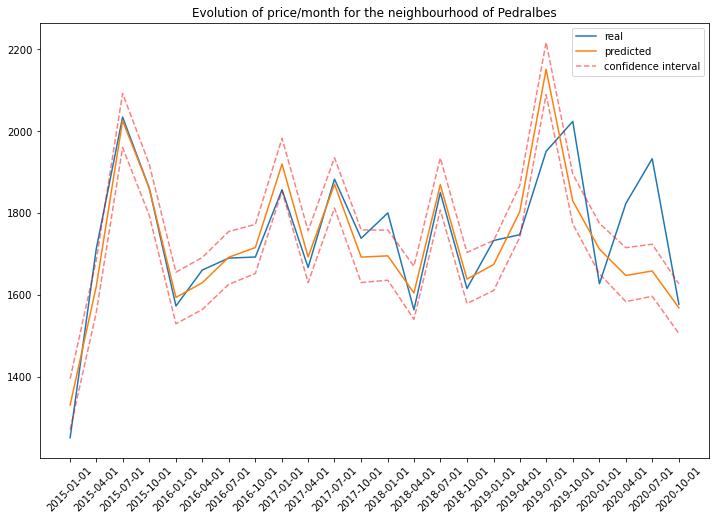

/home/antonia/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


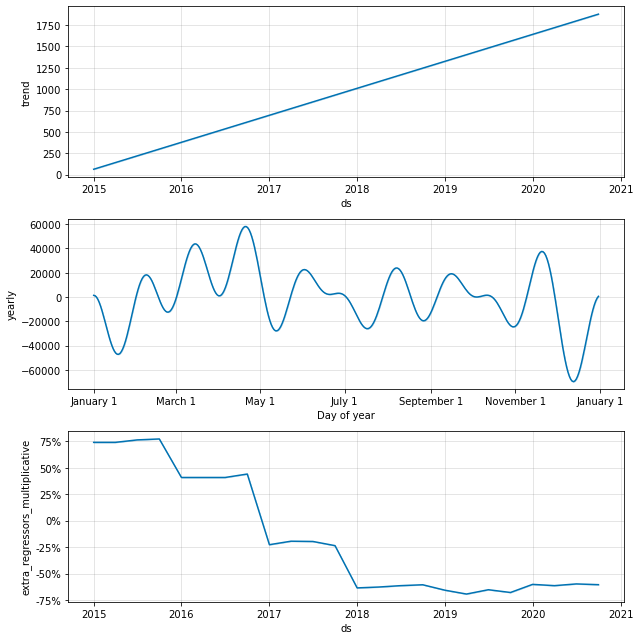

In [26]:
forecast_pedralbes = predict_rent_prophet('Pedralbes', 3, mode='multiplicative', scale=True, verbose=False)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Added regressors:
    -availability_365
    -more than 2 foreigners
    -bachelors degree


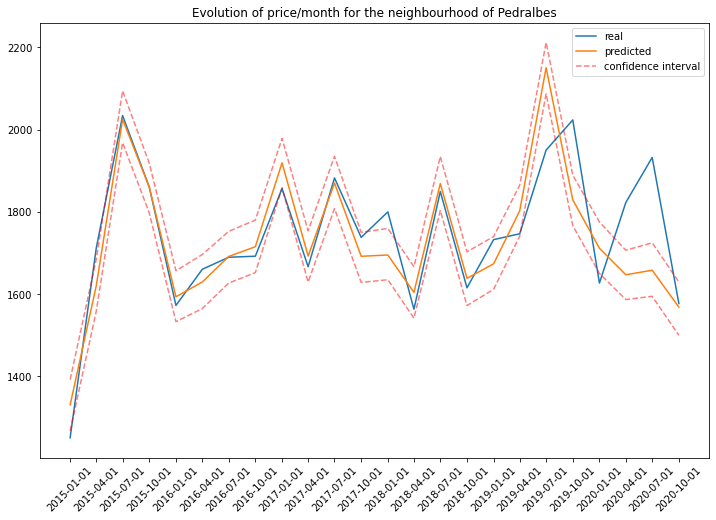

/home/antonia/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


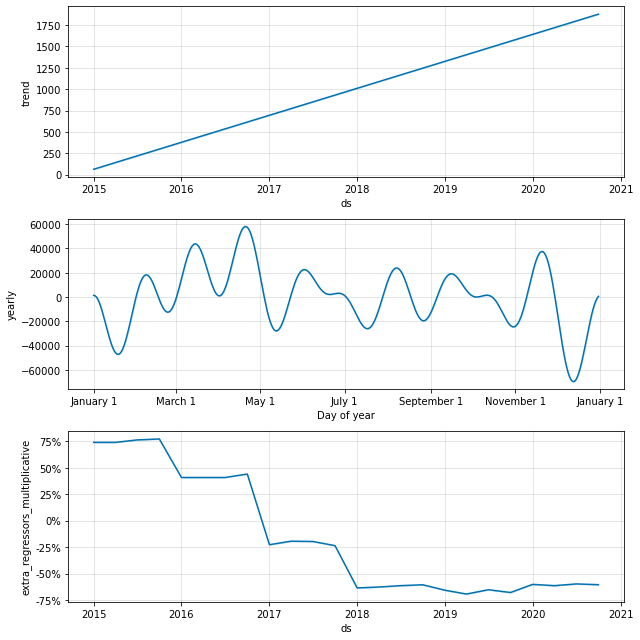

In [27]:
forecast_pedralbes_scaled = predict_rent_prophet('Pedralbes', 3, mode='multiplicative', scale=False)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Added regressors:
    -n_airbnb_listings
    -1 foreigner
    -long-term unemployment


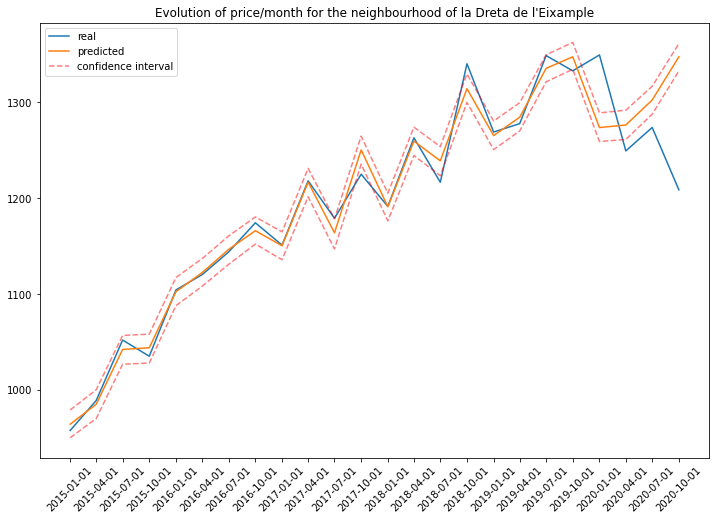

/home/antonia/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


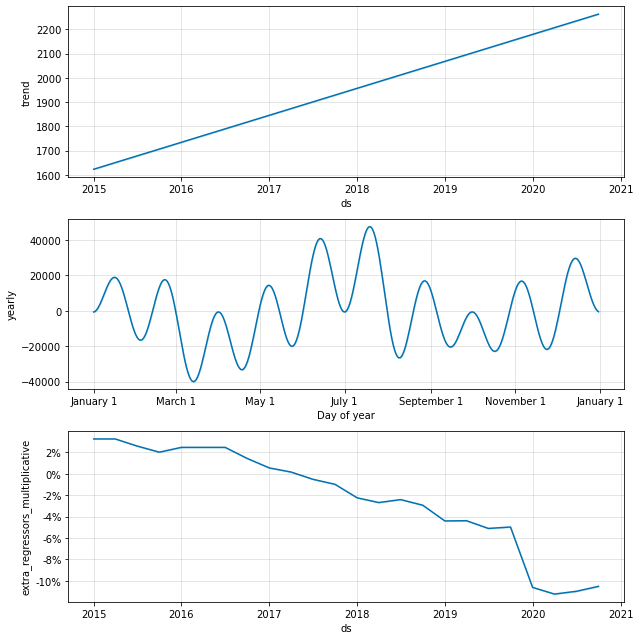

In [28]:
forecast_dreta_eixample = predict_rent_prophet("la Dreta de l'Eixample", 3, mode='multiplicative', scale=True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Added regressors:
    -availability_365
    -more than 2 Spanish
    -1 foreigner
    -bachelors degree
    -more than 2 foreigners


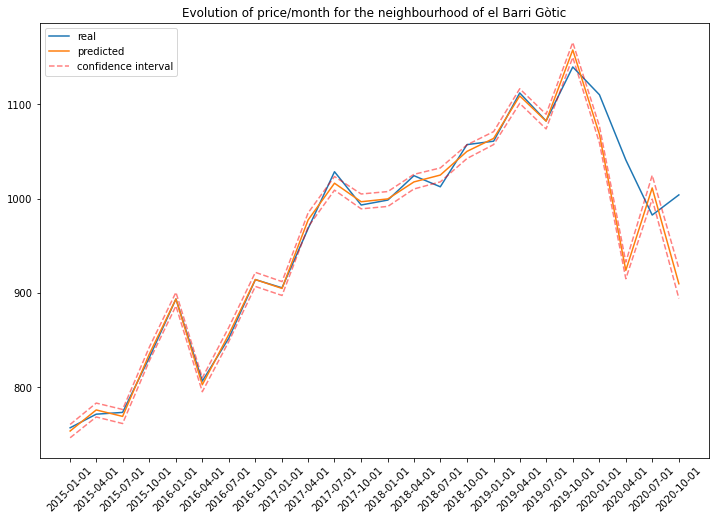

/home/antonia/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


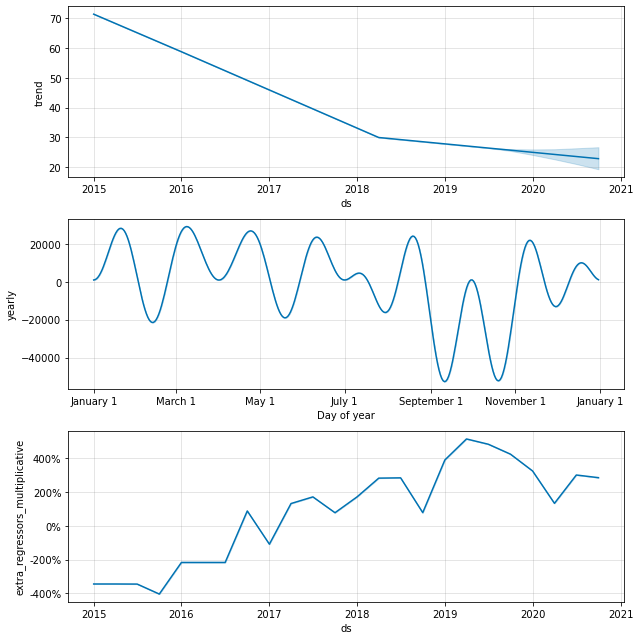

In [30]:
forecast_barri_gotic = predict_rent_prophet("el Barri Gòtic", 5, mode='multiplicative', scale=False)